In [1]:
import pandas as pd
import scutquant.scutquant as q

df = pd.read_csv("D:/Desktop/data.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df["mean_price"] = df["amount"] / df["vol"] * 10  # 每支股票在当天的交易均价
df

,datetime,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,amount,mean_price
0,2006-01-04,000001.SZ,6.13,6.33,6.12,6.28,6.14,0.14,2.2800,154450.68,96989.0066,6.279610
1,2006-01-04,000002.SZ,4.40,4.67,4.40,4.66,4.31,0.35,8.1200,389310.43,175187.0657,4.499933
2,2006-01-04,000012.SZ,4.70,4.75,4.55,4.70,4.62,0.08,1.7300,40399.61,18863.8625,4.669318
3,2006-01-04,000016.SZ,3.52,3.58,3.52,3.57,3.52,0.05,1.4200,14426.65,5131.8793,3.557222
4,2006-01-04,000021.SZ,7.99,8.40,7.99,8.32,8.00,0.32,4.0000,33526.60,27657.1708,8.249322
...,...,...,...,...,...,...,...,...,...,...,...,...
1199440,2022-12-30,688363.SH,136.00,137.00,131.50,135.28,135.49,-0.21,-0.1550,29951.60,401624.1560,134.091052
1199441,2022-12-30,688396.SH,53.06,53.40,52.49,52.65,52.87,-0.22,-0.4161,23401.54,123568.2880,52.803486
1199442,2022-12-30,688561.SH,65.49,67.88,64.85,65.77,65.46,0.31,0.4736,22567.89,149379.0770,66.190981
1199443,2022-12-30,688599.SH,63.31,64.56,62.31,63.76,63.20,0.56,0.8861,109144.36,695759.9350,63.746760


In [2]:
df.set_index(["datetime", "ts_code"], inplace=True)
df.index.names = ["datetime", "instrument"]

interest_data = pd.read_csv("D:/Desktop/capm.csv")
interest_data["RF"] = interest_data["RF"].shift(1).fillna(method="bfill") # 能对T时刻数据产生影响的，当为T-1的RF

print("Joining data, please wait...")
df = q.join_data(df, interest_data, col=["RF", "MKT"])

print("Making i factors...")
df["i1"] = df["pct_chg"] / df["RF"]  # (df["pct_chg"] / df["MKT"]) / (df["RF"] / df["MKT"])
#df["i2"] = df["pct_chg"] / df["MKT"] # 思路与上面相似
#df["i3"] = (df["pct_chg"] + df["RF"]) / (2 * df["MKT"]) # pct_chg和RF的均值 与市场收益率之比
#df["i4"] = 2 * df["pct_chg"] / (df["RF"] + df["MKT"]) # 将全部资金投资股票的收益率, 与将资金按1：1投资国债和市场组合的收益之比
#df["i5"] = (df["pct_chg"] - df["RF"]) / df["MKT"] 

df["i6"] = df["close"] / (df["close"].groupby("instrument").mean() * df["RF"])
df["i7"] = df["close"] / (df["close"].groupby("instrument").std() * df["RF"])
df["i8"] = (df["high"] + df["low"]) / (2 * df["RF"] * df["close"])
df["i9"] = df["vol"] / (df["vol"].groupby("instrument").mean() * df["RF"])
df["i10"] = df["vol"] / (df["vol"].groupby("instrument").std() * df["RF"])

print(df["open"].groupby("datetime").count())
df.info()

Joining data, please wait...
Making i factors...
datetime
2006-01-04    264
2006-01-05    267
2006-01-06    272
2006-01-09    269
2006-01-10    267
             ... 
2022-12-26    300
2022-12-27    300
2022-12-28    300
2022-12-29    300
2022-12-30    300
Name: open, Length: 4132, dtype: int64
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1199445 entries, (Timestamp('2006-01-04 00:00:00'), '000001.SZ') to (Timestamp('2022-12-30 00:00:00'), '688981.SH')
Data columns (total 18 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   open        1199445 non-null  float64
 1   high        1199445 non-null  float64
 2   low         1199445 non-null  float64
 3   close       1199445 non-null  float64
 4   pre_close   1199445 non-null  float64
 5   change      1199445 non-null  float64
 6   pct_chg     1199445 non-null  float64
 7   vol         1199445 non-null  float64
 8   amount      1199445 non-null  float64
 9   mean_price  1199445 non-null

In [3]:
df["label"] = df["pct_chg"].groupby("instrument").shift(-2) / 100
df = df.dropna()
df["label"].clip(-0.1, 0.1, inplace=True) 
df["label"].describe()

count    1.197673e+06
mean     5.829445e-04
std      2.843395e-02
min     -1.000000e-01
25%     -1.330000e-02
50%      0.000000e+00
75%      1.370000e-02
max      1.000000e-01
Name: label, dtype: float64

In [4]:
df = df.drop(["pct_chg", "change", "pre_close", "RF", "MKT"], axis=1)
df.corr()

,open,high,low,close,vol,amount,mean_price,i1,i6,i7,i8,i9,i10,label
open,1.000000,0.999825,0.999831,0.999663,-0.074657,0.277427,0.999812,0.000398,0.202408,0.060761,-0.023503,-0.003668,0.064045,-0.005175
high,0.999825,1.000000,0.999769,0.999862,-0.074264,0.279842,0.999930,0.005715,0.203397,0.061181,-0.024228,-0.001921,0.066403,-0.005246
low,0.999831,0.999769,1.000000,0.999838,-0.074679,0.275917,0.999923,0.004937,0.201853,0.060527,-0.022888,-0.004361,0.062864,-0.005177
close,0.999663,0.999862,0.999838,1.000000,-0.074348,0.278155,0.999946,0.010109,0.202895,0.060956,-0.023700,-0.002807,0.065016,-0.005471
vol,-0.074657,-0.074264,-0.074679,-0.074348,1.000000,0.607239,-0.074416,0.076687,0.052905,0.057366,0.024778,0.518415,0.391997,-0.000709
amount,0.277427,0.279842,0.275917,0.278155,0.607239,1.000000,0.278044,0.084353,0.240518,0.104144,0.017490,0.517958,0.497746,-0.008528
mean_price,0.999812,0.999930,0.999923,0.999946,-0.074416,0.278044,1.000000,0.006768,0.202745,0.060893,-0.023580,-0.002979,0.064812,-0.005219
i1,0.000398,0.005715,0.004937,0.010109,0.076687,0.084353,0.006768,1.000000,0.037143,0.022035,-0.018261,0.156980,0.158663,-0.015204
i6,0.202408,0.203397,0.201853,0.202895,0.052905,0.240518,0.202745,0.037143,1.000000,0.639964,0.603617,0.265226,0.284231,-0.026986
i7,0.060761,0.061181,0.060527,0.060956,0.057366,0.104144,0.060893,0.022035,0.639964,1.000000,0.468598,0.210485,0.265045,-0.022013


In [5]:
df.corr(method="spearman")

,open,high,low,close,vol,amount,mean_price,i1,i6,i7,i8,i9,i10,label
open,1.000000,0.999726,0.999759,0.999502,-0.299444,0.381984,0.999765,-0.006741,0.354330,0.265586,0.015043,0.078536,0.184432,-0.015185
high,0.999726,1.000000,0.999611,0.999773,-0.295026,0.386481,0.999903,0.006444,0.353805,0.264505,0.011523,0.083422,0.189366,-0.015217
low,0.999759,0.999611,1.000000,0.999732,-0.300672,0.380781,0.999864,0.004583,0.355189,0.266821,0.017160,0.077141,0.182872,-0.015581
close,0.999502,0.999773,0.999732,1.000000,-0.297030,0.384441,0.999890,0.017296,0.354623,0.265704,0.012925,0.081267,0.187097,-0.016174
vol,-0.299444,-0.295026,-0.300672,-0.297030,1.000000,0.722123,-0.297402,0.078427,0.072572,0.036666,0.083160,0.598820,0.498202,-0.007272
amount,0.381984,0.386481,0.380781,0.384441,0.722123,1.000000,0.384138,0.083054,0.292637,0.211142,0.064002,0.631674,0.620776,-0.017903
mean_price,0.999765,0.999903,0.999864,0.999890,-0.297402,0.384138,1.000000,0.008566,0.354555,0.265657,0.013965,0.080825,0.186662,-0.015425
i1,-0.006741,0.006444,0.004583,0.017296,0.078427,0.083054,0.008566,1.000000,0.012770,0.006983,-0.070456,0.094975,0.092339,-0.031948
i6,0.354330,0.353805,0.355189,0.354623,0.072572,0.292637,0.354555,0.012770,1.000000,0.810289,0.639482,0.338377,0.302675,-0.029055
i7,0.265586,0.264505,0.266821,0.265704,0.036666,0.211142,0.265657,0.006983,0.810289,1.000000,0.476297,0.267523,0.273973,-0.027275


In [6]:
from scutquant import alpha

kwargs = {
    "data": df,
    "open": "open",
    "close": "close",
    "high": "high",
    "low": "low",
    "volume": "vol",
    "amount": "amount",
}
X = alpha.make_factors(kwargs=kwargs)

X = pd.concat([X, df[["label", "i1", "i6", "i7", "i8", "i9", "i10"]]], axis=1)
X = X.dropna()
X

ROC5     BETA5  ROC10    BETA10   ROC20    BETA20  \
datetime   instrument                                                       
2006-04-07 000001.SZ  -0.180  0.003091 -0.084  0.002473 -0.0355  0.002241   
           000002.SZ  -0.144  0.008199 -0.010  0.013177  0.0395  0.013104   
           000059.SZ  -0.136  0.014918 -0.081  0.004429 -0.0225  0.006410   
           000061.SZ   0.018  0.039138  0.026  0.022621  0.0085  0.010503   
           000063.SZ  -0.030  0.005400  0.119  0.006957  0.1480  0.006290   
...                      ...       ...    ...       ...     ...       ...   
2022-12-28 688363.SH   2.158  0.017340  0.569  0.004919  1.3295  0.010144   
           688396.SH  -0.354 -0.002906 -0.497 -0.007491 -0.0550 -0.000094   
           688561.SH   0.610  0.012338 -0.054  0.000701  0.1825  0.003542   
           688599.SH   1.614  0.028922  0.706  0.012851 -0.1390 -0.001419   
           688981.SH  -0.278 -0.001907 -0.267 -0.004083 -0.0470  0.000073   

                          ROC30    BETA30     ROC60    BETA60  ...   VBETA20  \
datetime   instrument                                          ...             
2006-04-07 000001.SZ  -0.052000 -0.002885 -0.013500  0.000489  ...  0.005882   
           000002.SZ   0.007333  0.005954  0.019500  0.005295  ...  0.034371   
           000059.SZ  -0.025333  0.001865 -0.001167  0.003613  ...  0.022761   
           000061.SZ   0.002333  0.006403  0.004500  0.003800  ...  0.043437   
           000063.SZ   0.025667  0.001874  0.016500  0.001054  ...  0.040890   
...                         ...       ...       ...       ...  ...       ...   
2022-12-28 688363.SH   0.720000  0.005540  0.033167  0.000366  ...  0.005172   
           688396.SH  -0.060000 -0.000503  0.072667  0.001686  ... -0.011159   
           688561.SH  -0.112667 -0.001208  0.340333  0.005438  ... -0.052362   
           688599.SH  -0.148667 -0.001839 -0.084167 -0.001076  ...  0.011343   
           688981.SH  -0.086000 -0.001288  0.035167  0.001267  ... -0.013029   

                        VBETA30   VBETA60     label            i1  \
datetime   instrument                                               
2006-04-07 000001.SZ  -0.040639 -0.004851  0.026700  -4230.769231   
           000002.SZ   0.010459  0.004046  0.025300 -11043.956044   
           000059.SZ   0.010906  0.012590 -0.020700  17197.802198   
           000061.SZ   0.016114  0.006636 -0.001800  20439.560440   
           000063.SZ   0.021692  0.006023 -0.007900 -21318.681319   
...                         ...       ...       ...           ...   
2022-12-28 688363.SH  -0.018881  0.009401 -0.001550  -9662.666667   
           688396.SH  -0.052718 -0.013747 -0.004161  -9180.000000   
           688561.SH  -0.025249 -0.008797  0.004736 -14309.333333   
           688599.SH   0.007942  0.007798  0.008861  26640.000000   
           688981.SH  -0.085199  0.001016  0.006114  -9322.000000   

                                i6            i7           i8           i9  \
datetime   instrument                                                        
2006-04-07 000001.SZ   2290.592442   5498.275542  5507.243915   913.353208   
           000002.SZ   2233.846926   4322.296476  5591.041462  2969.223838   
           000059.SZ   2842.579407   7642.627966  5398.447706  3743.952974   
           000061.SZ   2269.700181   5344.324299  5385.996409  5932.382096   
           000063.SZ   6246.888508  13484.902787  5542.503875  1301.867887   
...                            ...           ...          ...          ...   
2022-12-28 688363.SH   5964.828784  21380.333166  6713.974067  8597.267933   
           688396.SH   5792.633578  29911.460522  6708.176101  1315.127701   
           688561.SH   7493.457941  39262.717088  6742.828129  4381.258175   
           688599.SH   6373.088194  50093.636972  6561.437075  6064.335676   
           688981.SH   6245.687461  64253.035931  6716.381418  3171.845024   

                                i10  
datetime   instrument         

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 862861 entries, (Timestamp('2006-04-07 00:00:00'), '000001.SZ') to (Timestamp('2018-12-28 00:00:00'), '603993.SH')
Data columns (total 40 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   ROC5     862861 non-null  float64
 1   BETA5    862861 non-null  float64
 2   ROC10    862861 non-null  float64
 3   BETA10   862861 non-null  float64
 4   ROC20    862861 non-null  float64
 5   BETA20   862861 non-null  float64
 6   ROC30    862861 non-null  float64
 7   BETA30   862861 non-null  float64
 8   ROC60    862861 non-null  float64
 9   BETA60   862861 non-null  float64
 10  KMID     862861 non-null  float64
 11  PERF1    862861 non-null  float64
 12  PERF2    862861 non-null  float64
 13  PERF3    862861 non-null  float64
 14  IDX1_5   862861 non-null  float64
 15  IDX1_10  862861 non-null  float64
 16  IDX1_20  862861 non-null  float64
 17  IDX1_30  862861 non-null  float64
 18  IDX1_60  862861 n

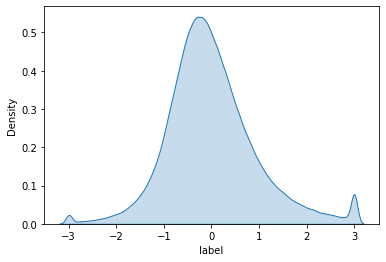

The distribution of y_test:


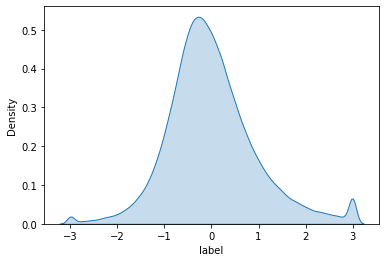

norm data done 

all works done 



In [7]:
X_train = X[X.index.get_level_values(0) <= "2018-12-31"]
X_test = X[X.index.get_level_values(0) >= "2019-01-01"]

# 处理训练集和验证集
result = q.auto_process(X_train, "label", groupby="instrument", datetime="datetime", 
                        split_params={"method": "split", "params": {"test": 0.3}}, select=False, orth=False)

X_train, y_train, X_valid, y_valid = result["X_train"], result["y_train"], result["X_test"], result["y_test"]

# 处理测试集
y_test = X_test.pop("label")
x_mean, x_std = X_test.groupby("datetime").mean(), X_test.groupby("datetime").std()
X_test = q.zscorenorm(X_test, x_mean, x_std)

y_mean = y_test.groupby("instrument").shift(2).groupby("datetime").mean()
y_std = y_test.groupby("instrument").shift(2).groupby("datetime").std()
y_mean.fillna(0.0002, inplace=True)  # 假设年化5%, 则每天应为0.0002
y_std.fillna(0.0189, inplace=True)  # 假设年化波动率为30%, 即0.3, 则每天的波动率应为0.0189

X_test = X_test.groupby("instrument").fillna(method="ffill").dropna()
y_test = y_test[y_test.index.isin(X_test.index)]

In [8]:
X_train.describe()

,ROC5,BETA5,ROC10,BETA10,ROC20,BETA20,ROC30,BETA30,ROC60,BETA60,...,VBETA10,VBETA20,VBETA30,VBETA60,i1,i6,i7,i8,i9,i10
count,604003.000000,604003.000000,604003.000000,604003.000000,604003.000000,604003.000000,604003.000000,604003.000000,604003.000000,604003.000000,...,604003.000000,604003.000000,604003.000000,604003.000000,604003.000000,604003.000000,604003.000000,604003.000000,604003.000000,604003.000000
mean,0.003641,0.012305,0.005008,0.016772,0.005725,0.019026,0.006279,0.019879,0.005855,0.019268,...,0.022991,0.025388,0.026817,0.028248,-0.008044,-0.010664,-0.013054,0.005811,-0.026960,-0.024552
std,0.771507,0.871308,0.770632,0.864352,0.775907,0.868998,0.779677,0.873368,0.789324,0.888032,...,0.877582,0.864504,0.855475,0.847647,0.942361,0.955389,0.940699,0.952788,0.866858,0.883175
min,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,...,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-2.652529,-3.000000,-3.000000,-1.885919,-2.381811
25%,-0.316817,-0.457966,-0.311131,-0.442685,-0.312723,-0.430870,-0.309776,-0.420132,-0.310254,-0.412400,...,-0.344830,-0.320527,-0.297270,-0.277898,-0.585875,-0.673658,-0.676507,-0.501713,-0.605052,-0.629555
50%,-0.013326,-0.005114,-0.009957,0.012217,0.001541,0.039032,0.006503,0.056191,0.016828,0.083665,...,0.178334,0.198735,0.208435,0.222921,-0.109423,-0.133446,-0.165903,0.074019,-0.249361,-0.254795
75%,0.295314,0.448966,0.300391,0.463634,0.302759,0.489910,0.310867,0.506366,0.321265,0.532968,...,0.604928,0.600701,0.593764,0.588621,0.470248,0.512649,0.494060,0.579355,0.301861,0.331598
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.733818,2.419728,2.153074,2.002069,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  39 | elapsed:    5.6s remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  16 out of  39 | elapsed:    5.8s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done  20 out of  39 | elapsed:    9.0s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done  24 out of  39 | elapsed:    9.2s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  28 out of  39 | elapsed:    9.4s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  32 out of  39 | elapsed:    9.4s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  36 out of  39 | elapsed:   10.7s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:   10.9s finished


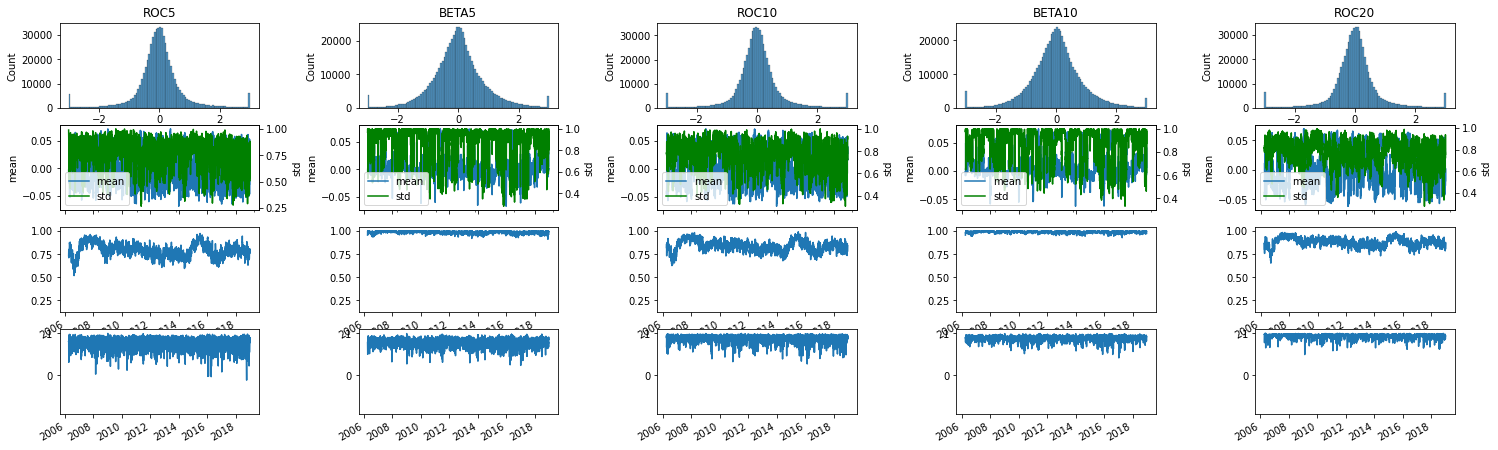

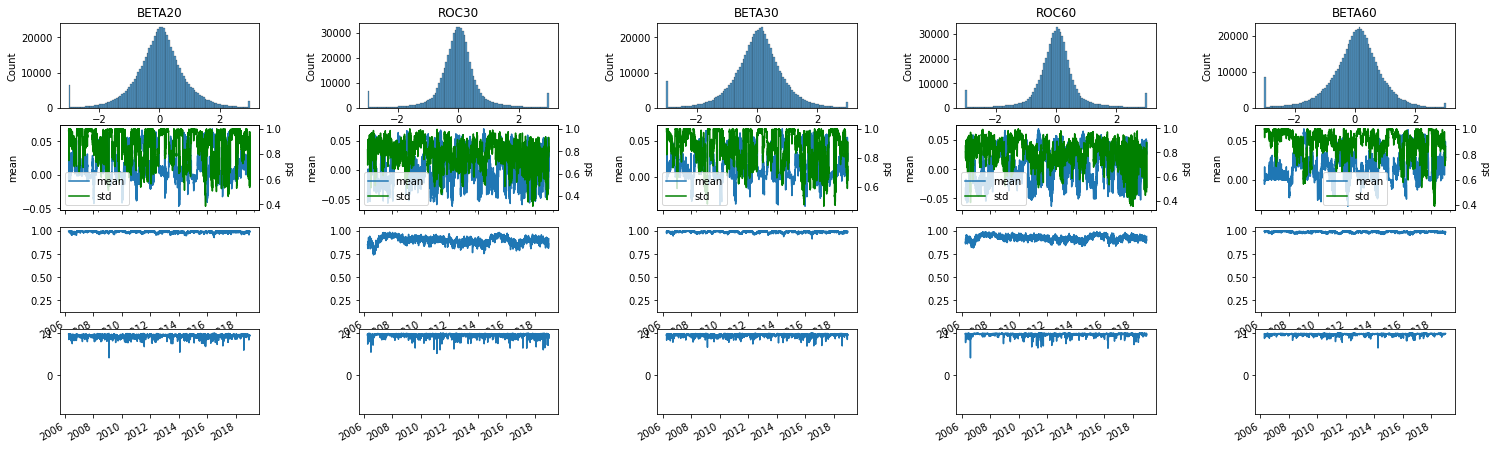

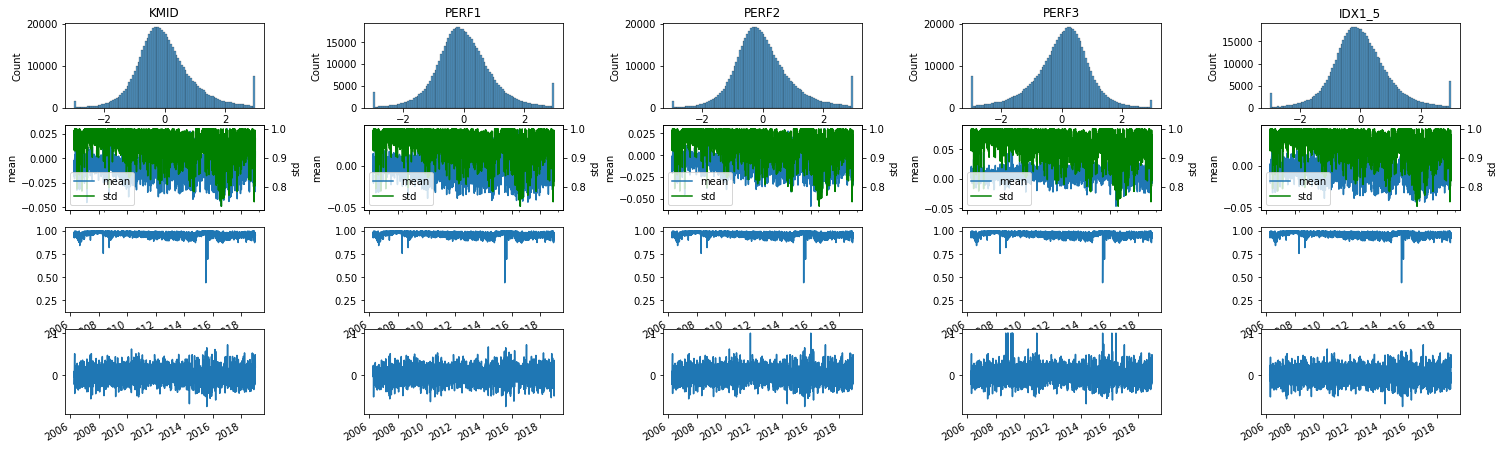

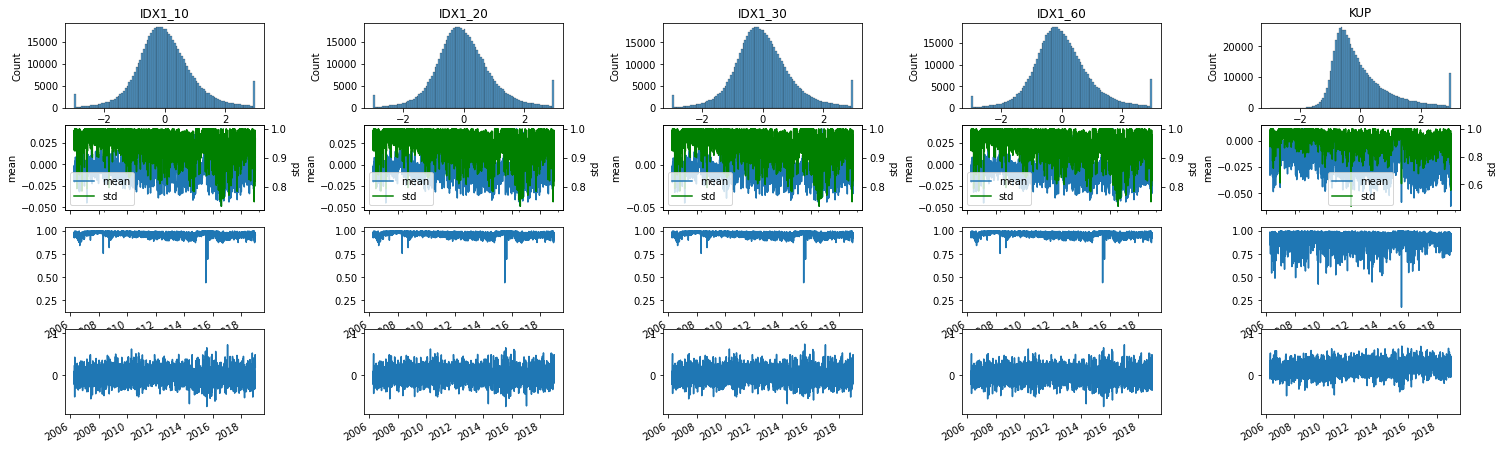

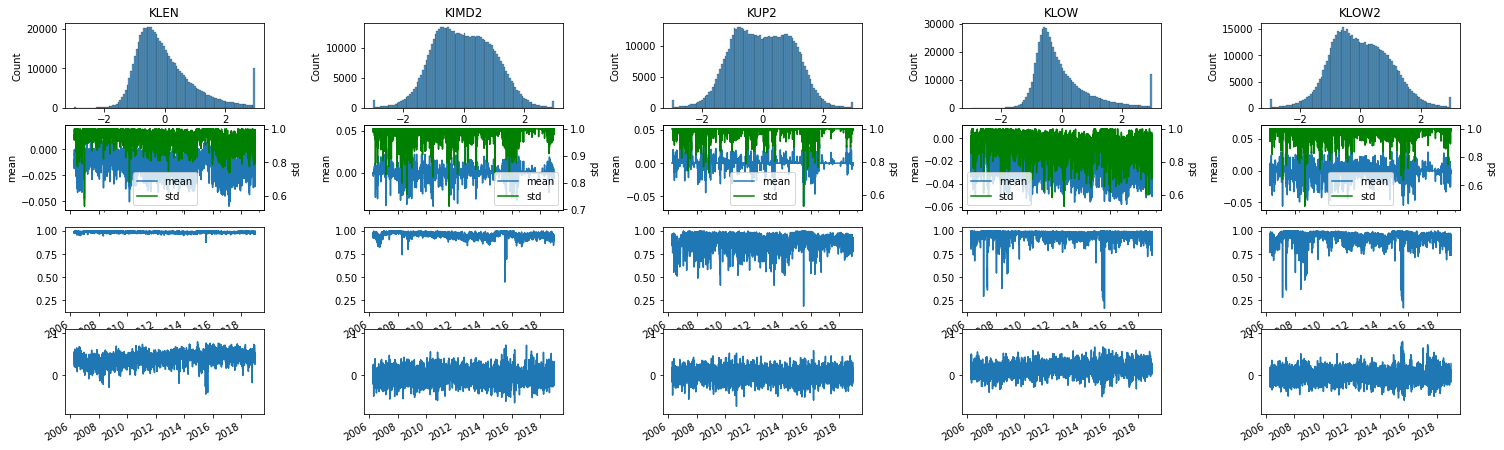

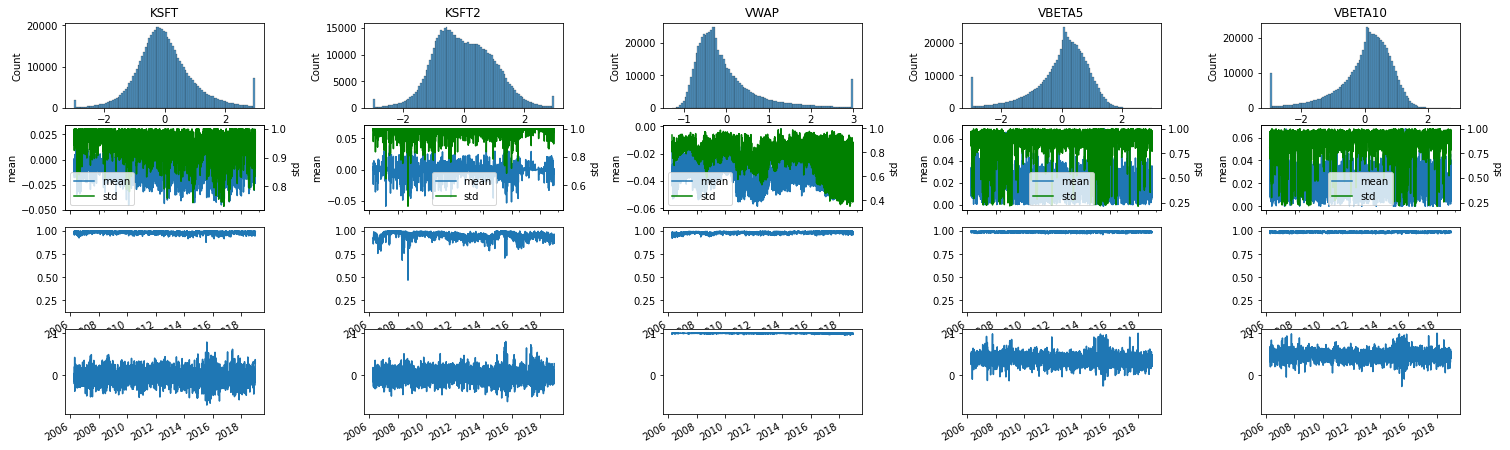

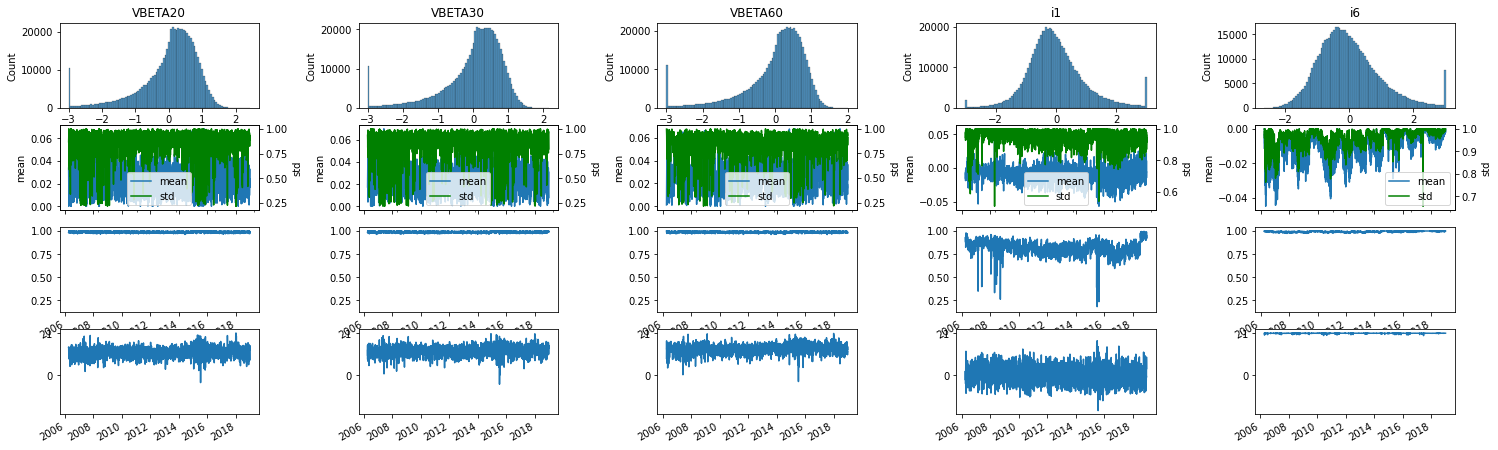

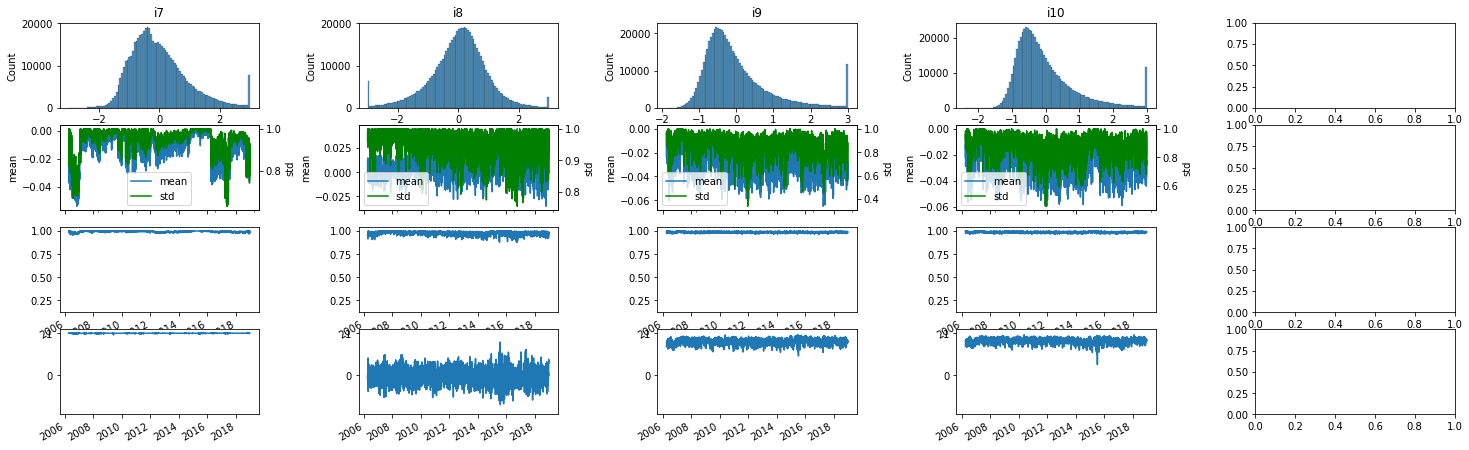

In [9]:
from functools import partial
from qlib.contrib.report.data.ana import CombFeaAna, FeaDistAna, FeaNanAnaRatio, FeaInfAna, FeaMeanStd, ValueCNT, FeaACAna, RawFeaAna

fa_full = CombFeaAna(X_train, FeaDistAna, FeaMeanStd, partial(ValueCNT, ratio=True), FeaACAna)
fa_full.plot_all(sub_fs=(5, 2), col_n=5, wspace=0.5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  39 | elapsed:   10.7s remaining:   24.2s
[Parallel(n_jobs=-1)]: Done  16 out of  39 | elapsed:   11.4s remaining:   16.5s
[Parallel(n_jobs=-1)]: Done  20 out of  39 | elapsed:   19.7s remaining:   18.7s
[Parallel(n_jobs=-1)]: Done  24 out of  39 | elapsed:   20.0s remaining:   12.4s
[Parallel(n_jobs=-1)]: Done  28 out of  39 | elapsed:   20.3s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  32 out of  39 | elapsed:   20.6s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done  36 out of  39 | elapsed:   25.1s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:   25.2s finished


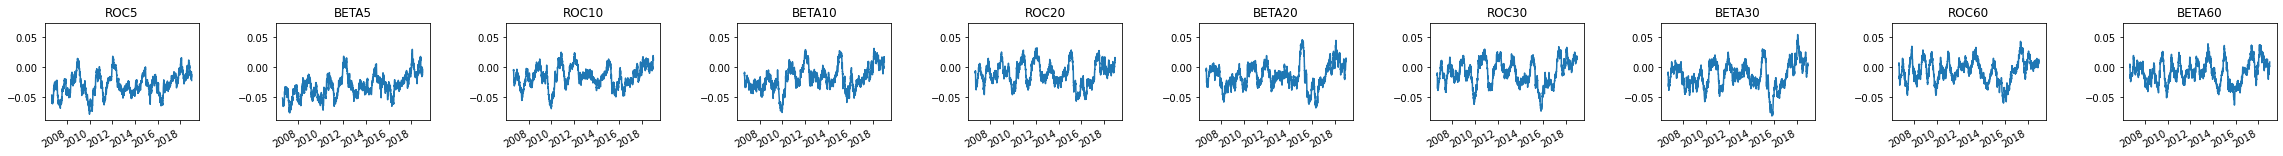

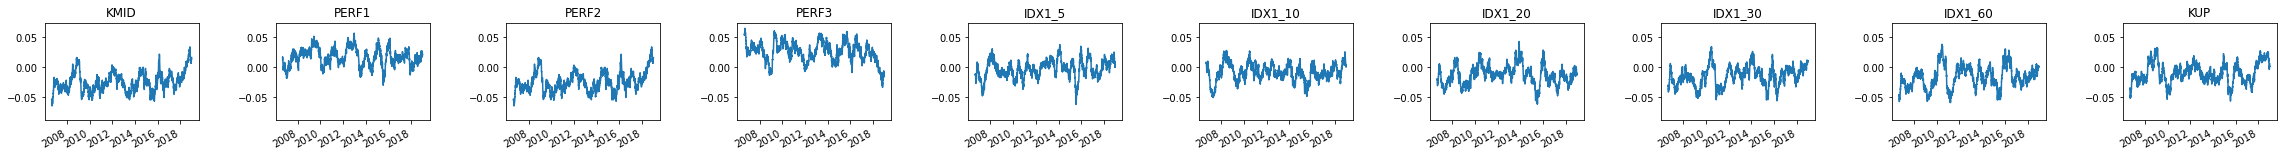

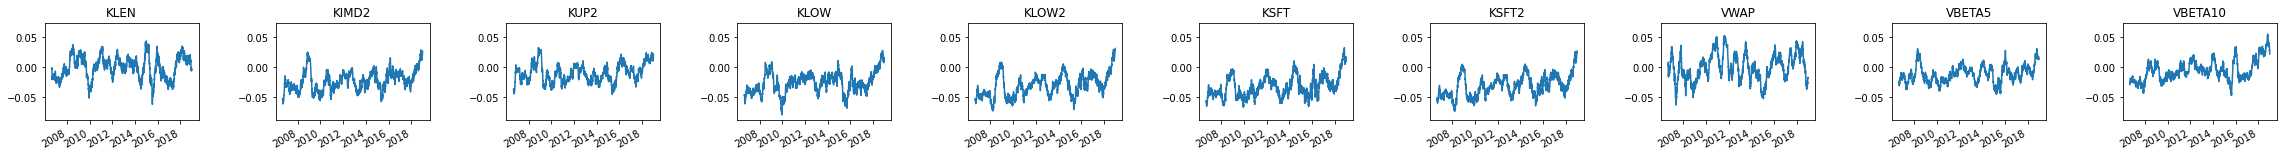

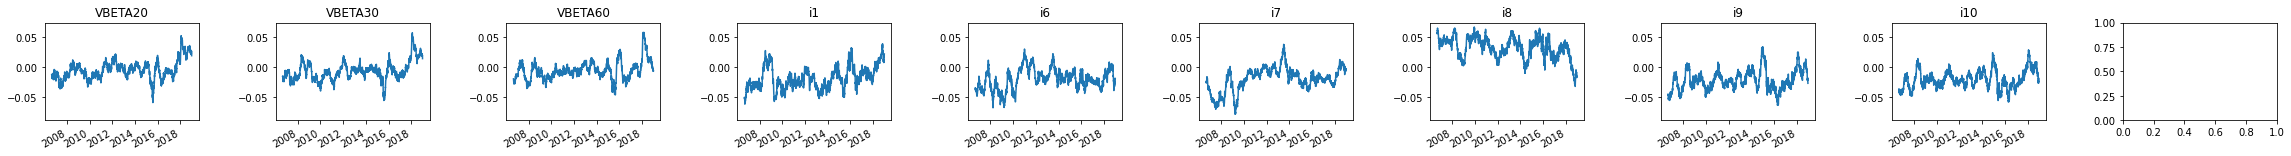

In [10]:
from qlib.contrib.eva.alpha import calc_all_ic

all_ic = calc_all_ic(X_train.to_dict('series'), y_train)
all_ic_df = pd.concat({f: d['ic'] for f, d in all_ic.items()})
all_ic_df = all_ic_df.unstack(0)

fa = RawFeaAna(all_ic_df.rolling(100).mean())
fa.plot_all(sub_fs=(4, 2), col_n=10, wspace=0.5)

<AxesSubplot:>

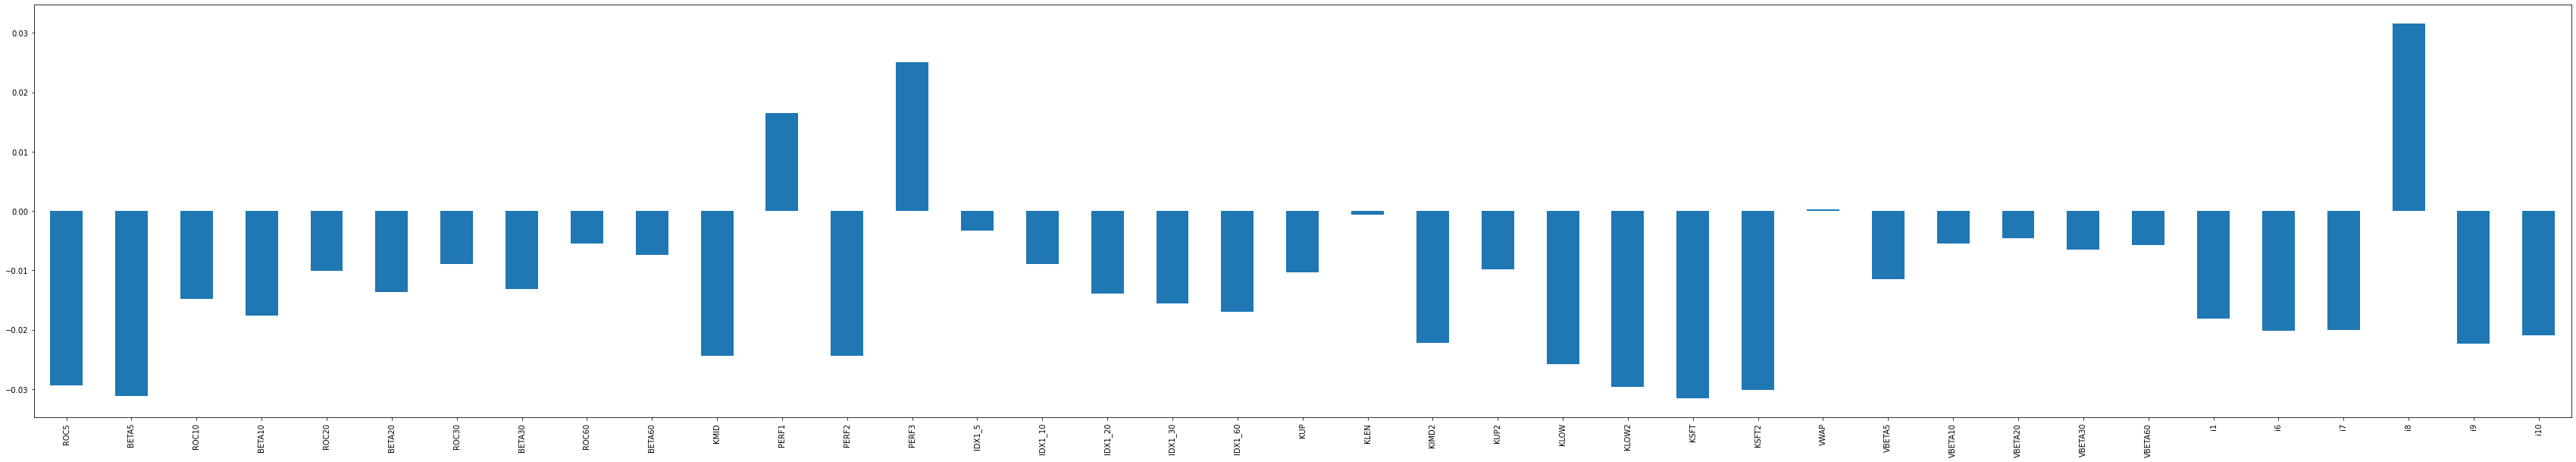

In [11]:
fig = all_ic_df.mean().plot(kind='bar', figsize=(60, 10))
fig

In [12]:
all_ic_df.mean().mean()

-0.012334641680708728

In [13]:
abs(all_ic_df.mean()).mean()

0.016092190259005833

In [14]:
all_ic_df.mean()

ROC5      -0.029384
BETA5     -0.031095
ROC10     -0.014748
BETA10    -0.017609
ROC20     -0.010075
BETA20    -0.013702
ROC30     -0.008875
BETA30    -0.013156
ROC60     -0.005440
BETA60    -0.007441
KMID      -0.024327
PERF1      0.016457
PERF2     -0.024341
PERF3      0.025015
IDX1_5    -0.003337
IDX1_10   -0.008941
IDX1_20   -0.013908
IDX1_30   -0.015537
IDX1_60   -0.017027
KUP       -0.010333
KLEN      -0.000670
KIMD2     -0.022254
KUP2      -0.009858
KLOW      -0.025773
KLOW2     -0.029593
KSFT      -0.031582
KSFT2     -0.030080
VWAP       0.000224
VBETA5    -0.011511
VBETA10   -0.005476
VBETA20   -0.004532
VBETA30   -0.006482
VBETA60   -0.005783
i1        -0.018083
i6        -0.020106
i7        -0.020018
i8         0.031576
i9        -0.022380
i10       -0.020867
dtype: float64

In [15]:
all_ic_df.mean() / all_ic_df.std()

ROC5      -0.177409
BETA5     -0.169081
ROC10     -0.086157
BETA10    -0.093078
ROC20     -0.058831
BETA20    -0.071900
ROC30     -0.052157
BETA30    -0.070357
ROC60     -0.032877
BETA60    -0.041875
KMID      -0.146574
PERF1      0.098584
PERF2     -0.146767
PERF3      0.151126
IDX1_5    -0.019895
IDX1_10   -0.053374
IDX1_20   -0.083200
IDX1_30   -0.093025
IDX1_60   -0.102034
KUP       -0.063805
KLEN      -0.003842
KIMD2     -0.148456
KUP2      -0.071317
KLOW      -0.161064
KLOW2     -0.209758
KSFT      -0.195253
KSFT2     -0.213065
VWAP       0.001375
VBETA5    -0.092612
VBETA10   -0.043766
VBETA20   -0.036087
VBETA30   -0.052546
VBETA60   -0.046272
i1        -0.105069
i6        -0.146200
i7        -0.181196
i8         0.195401
i9        -0.146063
i10       -0.139082
dtype: float64

In [16]:
model = q.auto_lgbm(X_train, y_train, X_valid, y_valid)

pred = model.predict(X_test)

pred = pd.DataFrame(pred, columns=["predict"], index=X_test.index)
pred["predict"] += y_mean
pred["predict"] *= y_std
pred.describe()

Training until validation scores don't improve for 30 rounds
[20]	train's l2: 0.88561	valid's l2: 0.899098
[40]	train's l2: 0.883871	valid's l2: 0.898188
[60]	train's l2: 0.882582	valid's l2: 0.89761
[80]	train's l2: 0.881523	valid's l2: 0.897235
[100]	train's l2: 0.880652	valid's l2: 0.896963
[120]	train's l2: 0.879867	valid's l2: 0.89677
[140]	train's l2: 0.879158	valid's l2: 0.896597
[160]	train's l2: 0.878461	valid's l2: 0.89645
[180]	train's l2: 0.877817	valid's l2: 0.896322
[200]	train's l2: 0.877149	valid's l2: 0.896203
[220]	train's l2: 0.876513	valid's l2: 0.896082
[240]	train's l2: 0.87588	valid's l2: 0.895972
[260]	train's l2: 0.875258	valid's l2: 0.89587
[280]	train's l2: 0.874602	valid's l2: 0.895769
[300]	train's l2: 0.873987	valid's l2: 0.895689
[320]	train's l2: 0.87341	valid's l2: 0.895633
[340]	train's l2: 0.872808	valid's l2: 0.895582
[360]	train's l2: 0.872216	valid's l2: 0.895564
[380]	train's l2: 0.871637	valid's l2: 0.895496
[400]	train's l2: 0.87113	valid's l2: 

,predict
count,281840.000000
mean,-0.000124
std,0.001657
min,-0.026704
25%,-0.000960
50%,-0.000046
75%,0.000814
max,0.017938


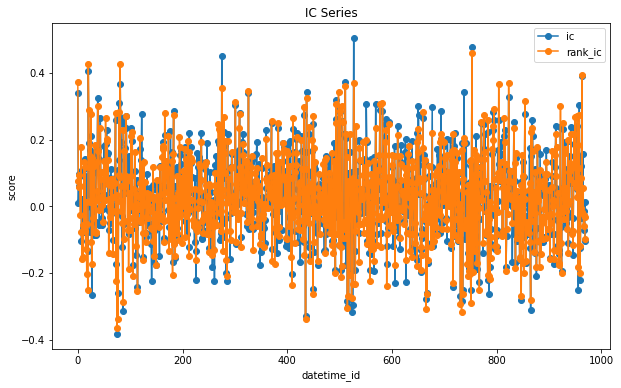

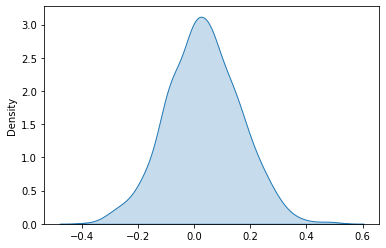

ic= 0.03157717377574625 icir= 0.24221716024245835 rank_ic= 0.026109705612838666 rank_icir= 0.2036495520969777


0.0271666592339501

In [17]:
ic, icir, rank_ic, rank_icir = q.ic_ana(pred["predict"], y_test, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)
# 使用pearson相关系数评判拟合优度
r = q.pearson_corr(pred["predict"].values, y_test)
r

In [19]:
from scutquant import executor, report

df_test = df[df.index.get_level_values(0) >= "2019-01-01"]
# 将预测值处理成回测需要的格式
pred = executor.prepare(pred, df_test, price='mean_price', volume='vol')
pred

predict       price     volume
time       code                                      
2019-01-02 000001.SZ  0.000215    9.252048  539386.32
           000002.SZ -0.002150   24.120738  247010.28
           000063.SZ  0.000347   19.088275  649682.72
           000069.SZ -0.001285    5.999183  403924.79
           000100.SZ -0.001204    2.515065  890514.27
...                        ...         ...        ...
2022-12-27 688363.SH -0.001663  136.312691   67620.51
           688396.SH  0.001091   53.127821   22894.05
           688561.SH -0.000893   65.791178   17585.16
           688599.SH -0.001839   62.192181  170829.80
           688981.SH -0.000405   41.078327   61293.26

[281386 rows x 3 columns]

Accuracy of Prediction: 0.5283347430220409


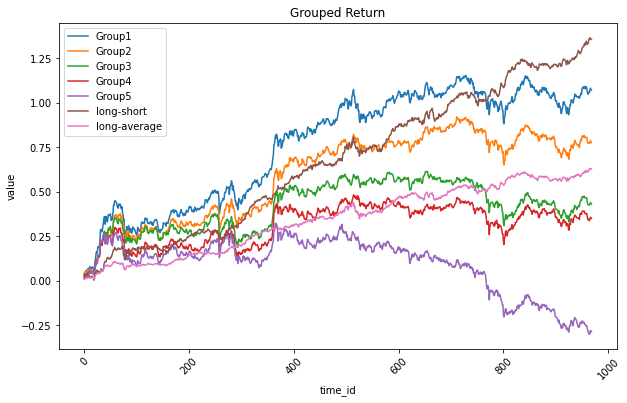

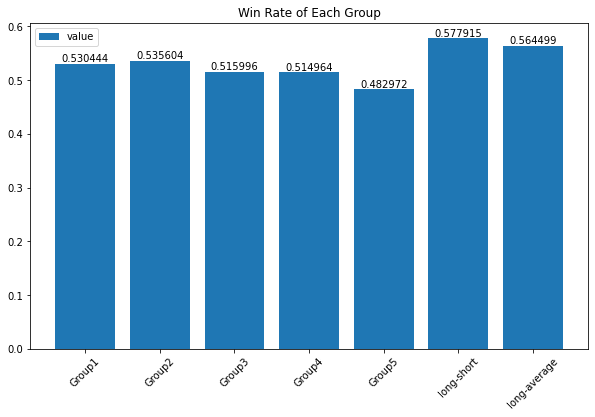

In [20]:
report.group_return_ana(pred, y_test)

In [21]:
backtest = {
    "generator": {
        "mode": "generate"
    },
    "strategy": {
        "class": "SigmaStrategy",  # 做多预测值前20%且值大于0%的股票, 做空后20%且值小于0%的股票. 自动平仓
        "kwargs": {
            "sigma": 1,
            "auto_offset": False,
            "offset_freq": 2, # 应为delta_t + 1, 例如目标值是close_-2 / close_-1 - 1, 则delta_t = 1
            "buy_only": False,  # =True时，只做多不做空(在A股做空有一定的难度)
            "short_volume": 5000,
            "risk_degree": 0.95,  # 将风险度控制在这个数，如果超过了就按比例减持股票直到风险度小于等于它为止
            "unit": None,  # 由于数据已经是以手为单位, 故无需二次处理
            "max_volume": 0.5  # 手数随可用资金而改变，最大不会超过股票当天成交量的x%(例如T+1时下单，下单手数不会超过T时成交量的x%)
        }
    },
    "account": None,  # 使用默认账户, 即初始资金为1亿, 无底仓
    "trade_params": {
        "cost_buy": 0.0015,  # 佣金加上印花税
        "cost_sell": 0.0005,  
        "min_cost": 5,
    }
}
generator, strategy, account, trade_params = backtest["generator"], backtest["strategy"], backtest["account"], backtest["trade_params"]
exe = executor.Executor(generator, strategy, account, trade_params)
exe.execute(data=pred, verbose=0)

Annualized Return: 0.1634810919026437
Annualized Volatility: 0.5729518089895335
Annualized Return(Benchmark): 0.07899686073853784
Annualized Volatility(Benchmark): 0.3389941216655789 

Cumulative Rate of Return: 0.7900298786509061
Cumulative Rate of Return(Benchmark): 0.33958556303554865
Cumulative Excess Rate of Return: 0.45044431561535747 

Max Drawdown: -0.37624785439736574
Max Drawdown(Benchmark): -0.5462600364770351 

Sharpe Ratio: 1.964747941070961
Sortino Ratio: 1.8663386074004904
Information Ratio: 0.5462024163717922 

Beta: 1.459192882573791
Alpha: -0.030770154323365717
Epsilon: 0.14743780612477836
Profitable Days(%): 0.7368421052631579


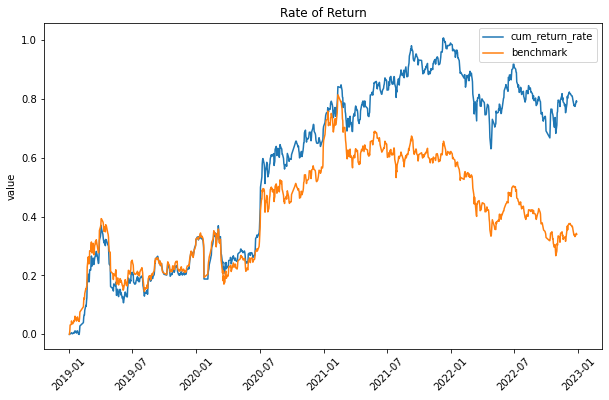

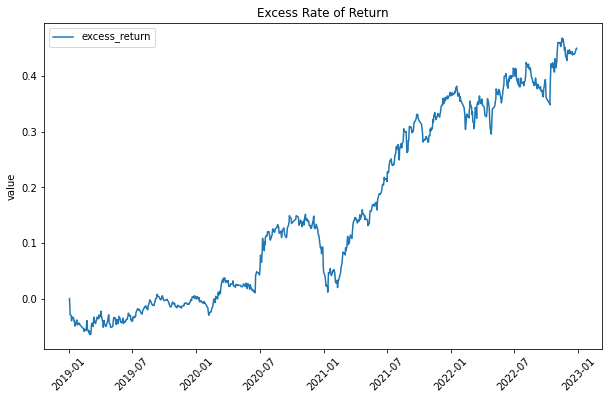

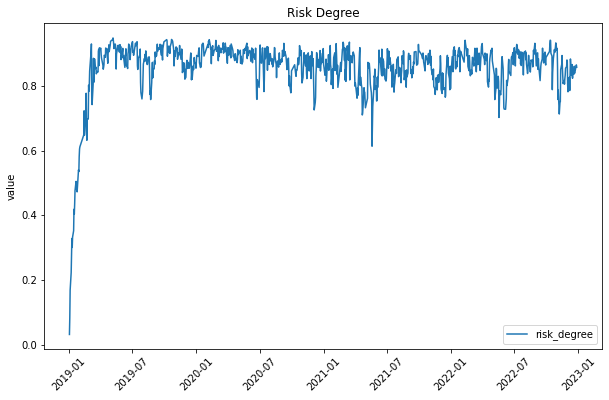

In [22]:
user_account, benchmark = exe.user_account, exe.benchmark
report.report_all(user_account, benchmark, freq=365, time=exe.time)  # 无风险收益率默认为年化3%，可以通过参数rf调节